# My Setup

I used PyCharm for development on this assignment. Below are my setup steps
```
mkdir venv
python3 -m venv ./venv
source venv/bin/activate
pip install -r requirements.txt
```

In PyCharm Settings add the local interpreter to the project configs.
```
Preferences -> Project -> Python Interpretter -> Add Local Interpretter
```

# Import data

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [66]:
wine_data_frame = pd.read_csv('winequality-red.csv')
wine_data_frame.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


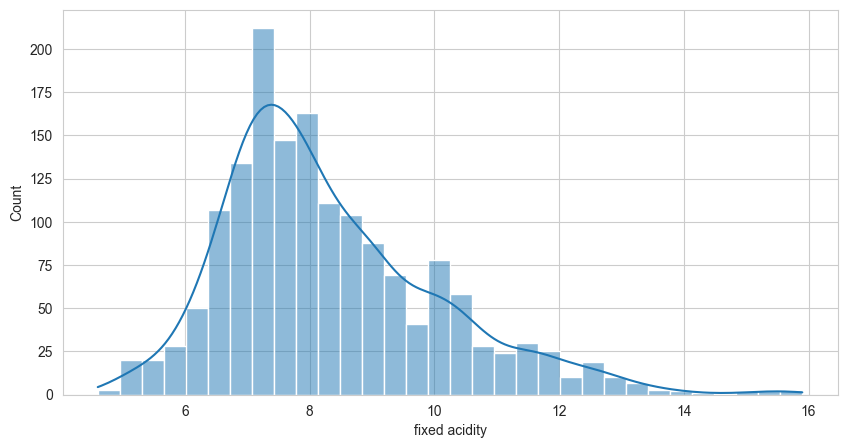

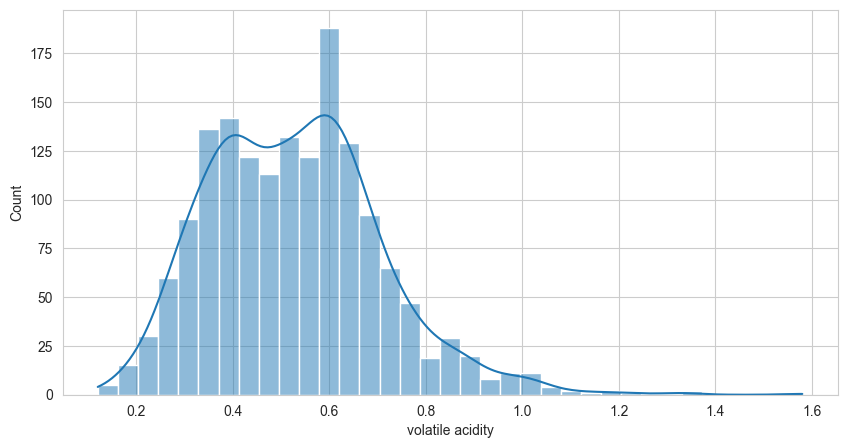

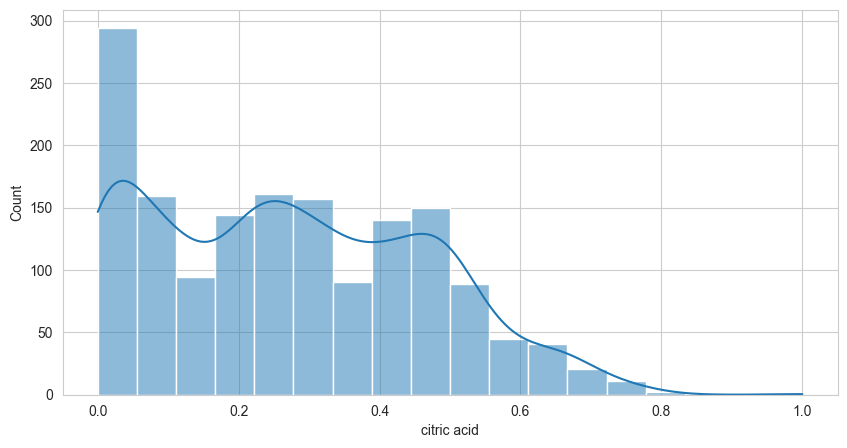

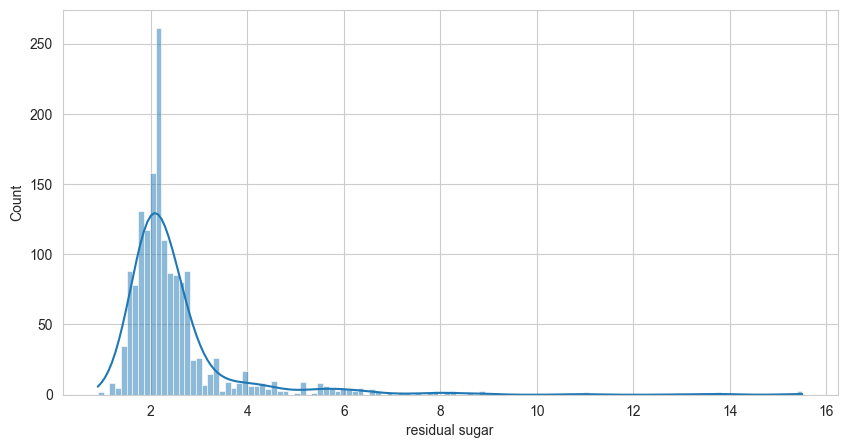

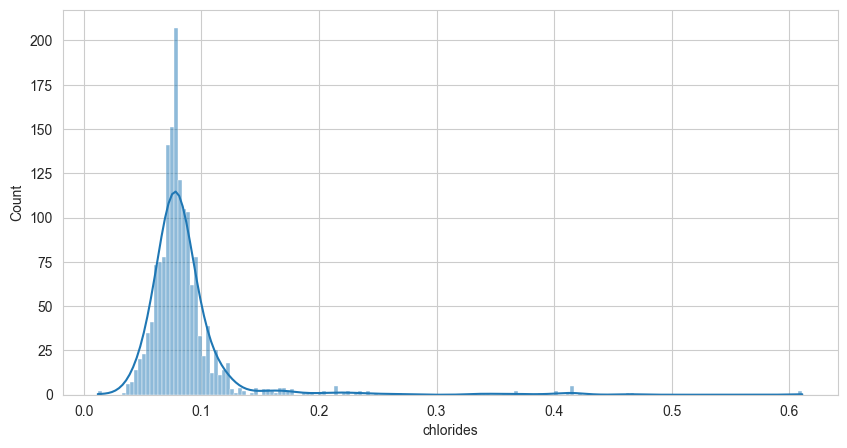

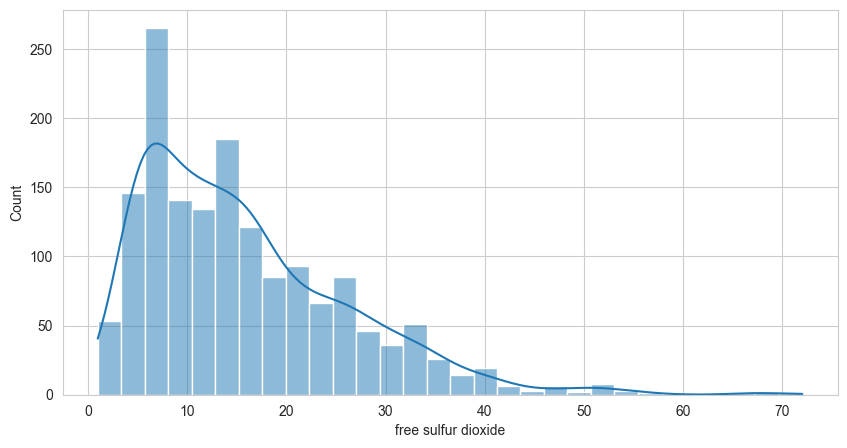

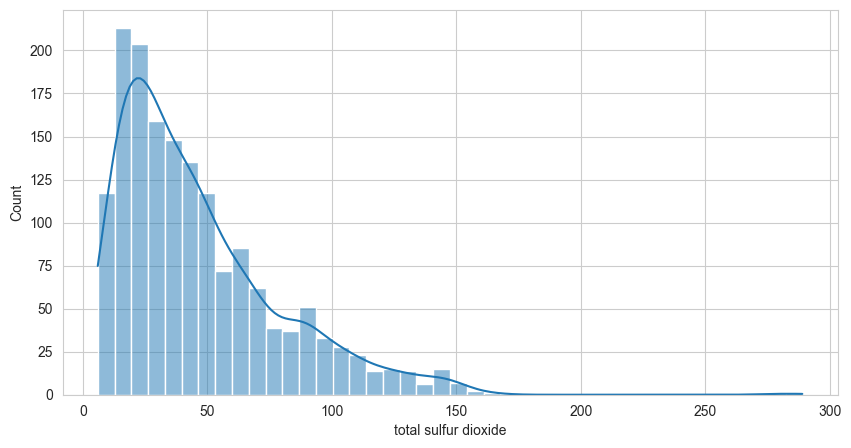

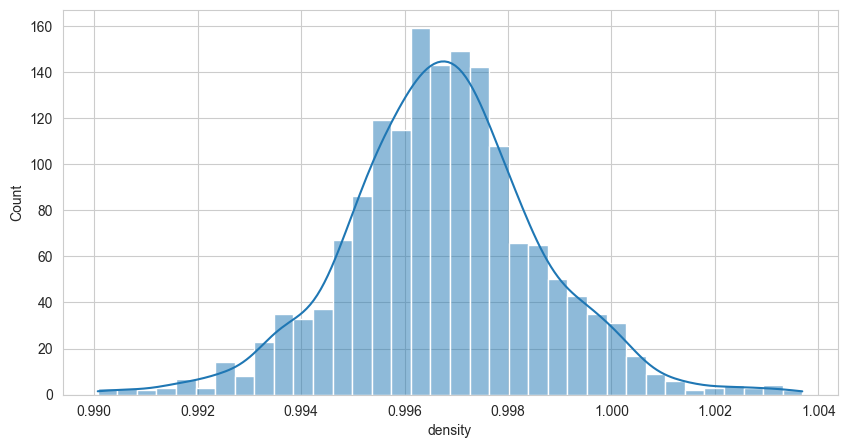

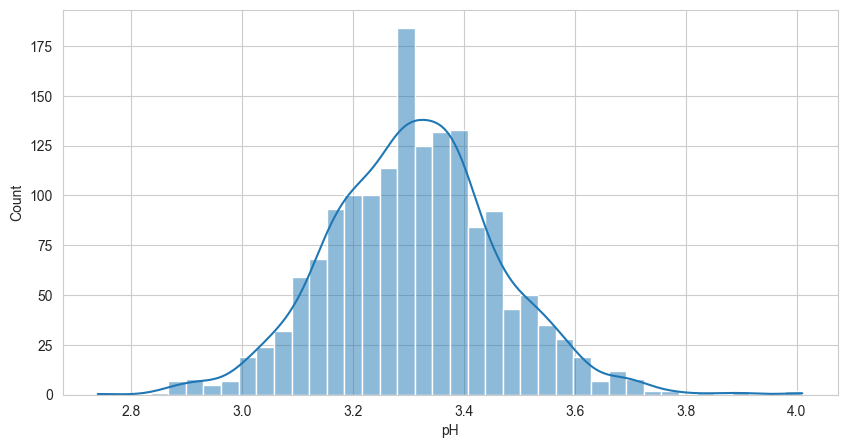

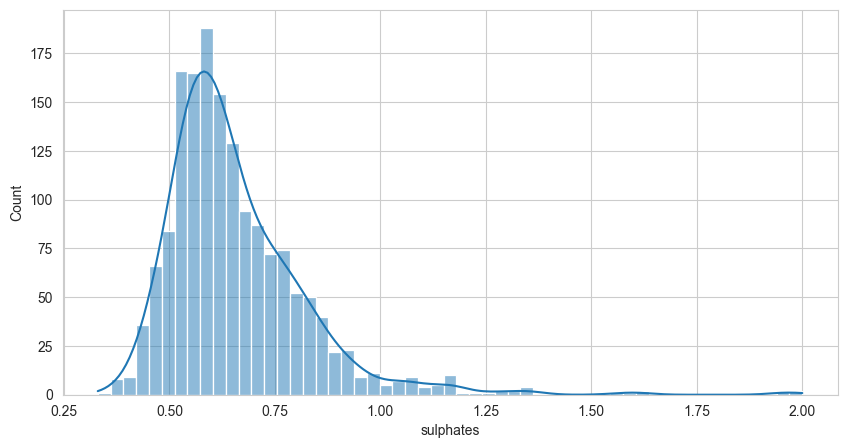

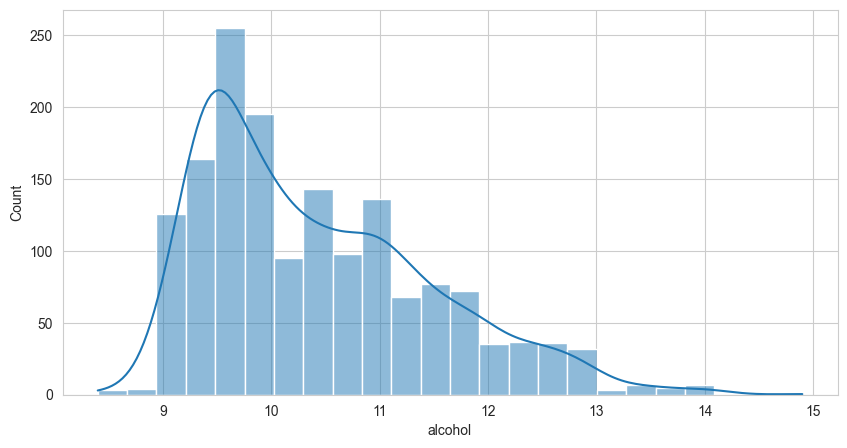

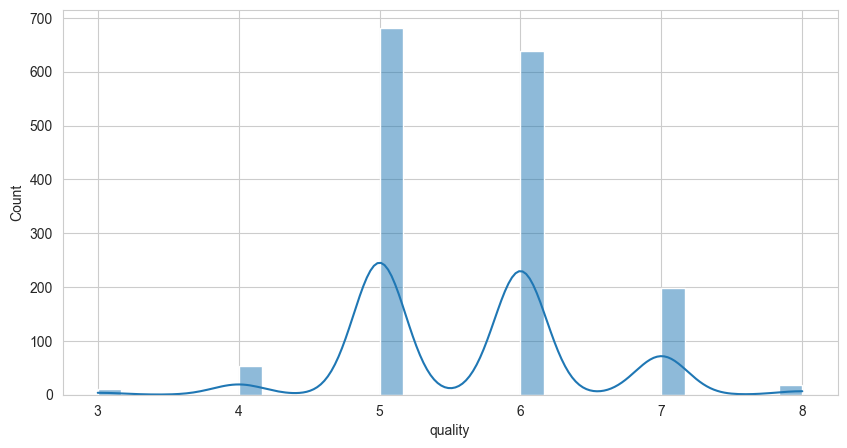

In [67]:
# Inspect the dataframe and see if there are any missing values
wine_data_frame.info()

for col in wine_data_frame.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=wine_data_frame[col], kde=True)

In [68]:
# All fields appear to be non-null.
standard_scaler = StandardScaler()

# Split data frame's features and targets
x = wine_data_frame.iloc[:, :-1]
y = wine_data_frame.iloc[:, -1]

# Acquire the train, test, and validation sets
# 0.3 will be split into 0.15 and 0.15 for the test and validation
train_x, everything_else_x, train_y, everything_else_y = \
    train_test_split(x, y, test_size=0.3, random_state=42)

# Inspect the train shape to make sure it's 70%
print("------------------------------\n"
      "train_x shape                 \n"
      "------------------------------")
print(train_x.shape)

# Now get the validation and test sets. Split the test size in half so that 0.15 and 0.15 split the 0.3
valid_x, test_x, valid_y, test_y = \
    train_test_split(everything_else_x, everything_else_y, test_size=0.5, random_state=42)

# Inspect the validation and test shapes to make sure it's 15% each to make 30%
print("\n------------------------------\n"
      "valid_x shape                 \n"
      "------------------------------")
print(valid_x.shape)

print("\n------------------------------\n"
      "test_x shape                 \n"
      "------------------------------")
print(test_x.shape)

# Wrangle the data into tensor data structures and inspect their data structure to verify
train_x = torch.tensor(train_x.to_numpy())
test_x = torch.tensor(test_x.to_numpy())
valid_x = torch.tensor(valid_x.to_numpy())

train_y = torch.tensor(train_y.to_numpy())
test_y = torch.tensor(test_y.to_numpy())
valid_y = torch.tensor(valid_y.to_numpy())

# Convert the features to float32
train_x = train_x.float()
test_x = test_x.float()
valid_x = valid_x.float()

------------------------------
train_x shape                 
------------------------------
(1119, 11)

------------------------------
valid_x shape                 
------------------------------
(240, 11)

------------------------------
test_x shape                 
------------------------------
(240, 11)


# Creating a basic MLP

In [75]:
# Put the tensors into a Dataset in order to get the DataLoader
class WineDataset(Dataset):
    def __init__(self, x_input, y_input):
        self.x = x_input
        self.y = y_input

    def __getitem__(self, index: int) -> tuple:
        """
        Get the x and y item at the specified index.
        :param index: int of the index to retrieve the item in the x and y data structure for the WineDataset.
        :return: Tuple of the items at x[index] and y[index]
        """
        return self.x[index], self.y[index]

    def __len__(self):
        """
        Length of the WineDataset in the x-dimension
        :return:
        """
        return len(self.x)


# Create instance of WineDataset
wine_dataset_train = WineDataset(train_x, train_y)

# Using the Dataset, create DataLoader which will batch and possibly randomize the data.
train_loader = DataLoader(dataset=wine_dataset_train, batch_size=8)

# Build the Multi-Layer Perceptron
class WineMLP(torch.nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(WineMLP, self).__init__()
        self.inputs = n_inputs
        self.hidden = hidden_size
        self.outputs = n_outputs

        # Create the layers
        self.linear1 = torch.nn.Linear(self.inputs, self.hidden)
        self.linear2 = torch.nn.Linear(self.hidden, self.outputs)

        # Assign the activation function
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        out = self.linear1(X)
        out = self.relu(out)
        out = self.linear2(out)
        return out


In [106]:
num_features = train_x.shape[1]  # There are 11 features in this dataset

# Go one more past the highest value to have enough output nodes
highest_quality = wine_data_frame["quality"].max() + 1

model = WineMLP(n_inputs=num_features, hidden_size=6, n_outputs=highest_quality)

# Inspect the model
print("-------------------------\n"
      "Inspect Model            \n"
      "---------------------------")
print(model)

# Prepare the loss function and optimizer for running data through the network.
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

# Begin pushing data through the network
epochs = 10

for epoch in range(epochs):
    for features, targets in train_loader:
        # Acquire the model's hypothesis
        output = model.forward(features)

        # Calculate the loss from the hypothesis, remove prev losses, and back propagate
        loss = criterion(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Put the model in evaluation mode. This does not do back propagation
model.eval()
validation_hypothesis = model.forward(valid_x)
validation_hypothesis.shape

# Validation hypothesis will give the cross entropy losses for each of the classifications.
# Inspect a few of them
print("\n"
      "------------------------------------\n"
      "Inspection of Cross Entropy Losses  \n"
      "------------------------------------")
for hypothesis in validation_hypothesis[:5]:
    print([round(float(item), 3) for item in hypothesis.tolist()])

# argmax will give us the position of the item with the highest value
print("\n"
      "--------------------------------------\n"
      "Inspection of which index in the cross\n"
      "entropy losses are predicting print   \n"
      "the first 30 rows of predictions.     \n"
      "------------------------------------")
categories = torch.argmax(validation_hypothesis, dim=1)
print(str(categories[:30]) + "....")

print("\n"
      "--------------------------------------\n"
      "Validation Accuracy                   \n"
      "--------------------------------------")
validation_accuracy = (categories == valid_y).sum() / validation_hypothesis.shape[0]
print(validation_accuracy)

-------------------------
Inspect Model            
---------------------------
WineMLP(
  (linear1): Linear(in_features=11, out_features=6, bias=True)
  (linear2): Linear(in_features=6, out_features=9, bias=True)
  (relu): ReLU()
)

------------------------------------
Inspection of Cross Entropy Losses  
------------------------------------
[-3.591, -4.803, -3.617, -1.154, 1.348, 4.382, 5.035, 3.499, -0.193]
[-2.85, -3.665, -2.89, -0.832, 1.106, 3.445, 4.03, 2.743, -0.23]
[-2.024, -2.396, -2.079, -0.473, 0.836, 2.401, 2.909, 1.899, -0.27]
[-2.422, -3.008, -2.47, -0.646, 0.966, 2.904, 3.45, 2.306, -0.251]
[-1.825, -2.09, -1.883, -0.386, 0.771, 2.148, 2.639, 1.695, -0.28]

--------------------------------------
Inspection of which index in the cross
entropy losses are predicting print   
the first 30 rows of predictions.     
------------------------------------
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6])....

-------------

# Making changes to basic MLP

In [ ]:
# Add steps

# Optional: Implementing the MLP

In [ ]:
# Add steps